<h1 align="center"> The Donor's Choose challenge</h1>


![](https://cdn.donorschoose.net/images/logo/dc-logo.png)


Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

The goal of this problem originally posted on [Kaggle](https://www.kaggle.com/c/donorschoose-application-screening) is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

I will be doing some text cleaning, feature engineering and Neural Networks, particularly the LSTM to try and give a solution for this problem. Let's begin.

In [59]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss
import pandas as pd
from keras.optimizers import adam, RMSprop
from keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy import asarray
from keras.models import Model, Sequential
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Embedding, Flatten, concatenate, Dropout, Conv1D
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.callbacks import TensorBoard

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Processing text data

I will be using a processed csv file already available with me. But it still needs to be further changed.

Keras or any other ML library cannot accept raw text data of `essay`, or categorical variables like `school_state`. Before we build our neural net models, we need to bring this data into a format that is suitable for feeding into a model. i.e. we need to convert them into numbers.

In [3]:
df_donors = pd.read_csv('./preprocessed_data.csv')

In this data, **project_is_approved** is the target variable

In [4]:
df_donors.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


**Create Train test, CV, test sets**

In [5]:
from sklearn.model_selection import train_test_split

df_X_train_CV, df_X_test, y_train_CV, y_test = train_test_split(
    df_donors.drop('project_is_approved', axis=1),
    df_donors['project_is_approved'],
    test_size=.20)

df_X_train, df_X_CV, y_train, y_CV = train_test_split(df_X_train_CV,
                                                   y_train_CV,
                                                   test_size=0.20)

In [6]:
df_donors.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

**Features**

Our data has these features. We'll process each one of them in some way.

    1 essay --> Embedding using pretrained Glove. Trainable = False
    2 school_state --> Categorical --> Embedding. Trainable = True
    3 grade_category --> Categorical --> Embedding. Trainable = True
    4 clean_category --> Categorical --> Embedding. Trainable = True
    5 clean_subcategory --> Categorical --> Embedding. Trainable = True
    6 teacher_prefix --> Categorical --> Embedding. Trainable = True
    7 teacher_number_of_previously_posted_projects --> Numerical feature.
    
Let's begin with the first and the most important feature - essay.

In [7]:
df_X_train.shape, df_X_CV.shape, df_X_test.shape

((69918, 8), (17480, 8), (21850, 8))

In [8]:
y_train.shape, y_CV.shape, y_test.shape

((69918,), (17480,), (21850,))

## 1. Essay

    step 1. Tokenize the essays
    step 2. Pad the tokenized essays so that each one of them has a fixed length
    step 3. Load the pretrained GloVe embeddings for words from the 300 dimensional version
    step 4. create an embedding matrix, which stores the 300 dim vetor for each word in the vocabulary
    step 5. Define the embedding and the LSTM layer 

In [6]:
t_essays = Tokenizer()
t_essays.fit_on_texts(df_X_train.essay.tolist())
encoded_docs_train = t_essays.texts_to_sequences(df_X_train.essay.tolist())

There are 47189 words in the vocabulary

In [7]:
vocab_size_essays = len(t_essays.word_index) + 1
print(vocab_size_essays)

47453


**obtain the tokenized essay representation for CV and Test sets**

In [8]:
encoded_docs_CV = t_essays.texts_to_sequences(df_X_CV.essay.tolist())
encoded_docs_test = t_essays.texts_to_sequences(df_X_test.essay.tolist())

**Pad the inputs**

Instead of padding all the essays (docs) with the same maximum length, let's see how the number of words in essays are distributed.

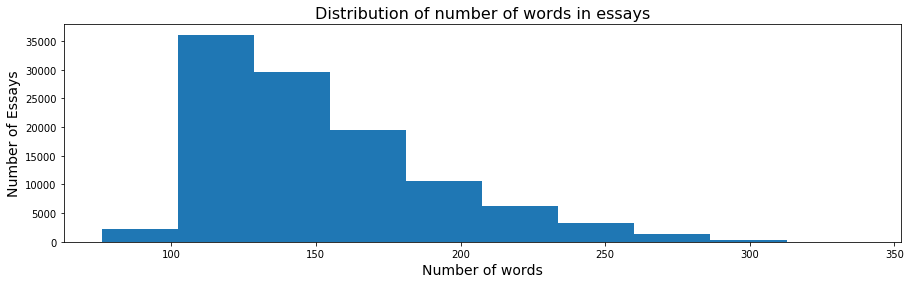

In [12]:
df_donors.essay.str.split().apply(len).plot.hist(figsize=(15,4))
plt.title('Distribution of number of words in essays', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Number of Essays', fontsize=14)
plt.show()

**The 95th percentile of #words in essays is 231**. Which means most of the essays have much lower word count than the essay with maximum word count(339) in the dataset. If we pad the lengths to `339`, most of the other essays would have redundant 0 inputs. Instead, let's keep the max length of essay inputs to 231. Doing this would also improve the training time because fewer parameters would have to be trained.

In [9]:
pctile_95_wc = df_donors.essay.str.split().apply(len).quantile(.95)
max_wc = df_donors.essay.str.split().apply(len).max()

print('95th Percentile word count in Essays:', pctile_95_wc)
print('Maximum word count in essays:', max_wc)

95th Percentile word count in Essays: 231.0
Maximum word count in essays: 339


In [10]:
padded_docs_train = pad_sequences(encoded_docs_train,
                                  maxlen=int(pctile_95_wc),
                                  padding='post',
                                  truncating='post')
padded_docs_CV = pad_sequences(encoded_docs_CV,
                               maxlen=int(pctile_95_wc),
                               padding='post',
                               truncating='post')
padded_docs_test = pad_sequences(encoded_docs_test,
                                 maxlen=int(pctile_95_wc),
                                 padding='post',
                                 truncating='post')

As expected, the each essay in each of the sets has an input length of 231.

In [15]:
padded_docs_train.shape ,padded_docs_CV.shape, padded_docs_test.shape

((69918, 231), (17480, 231), (21850, 231))

**Load pretrained Glove embedding for essays**

In [16]:
# load the whole embedding into memory
embeddings_index = dict()
errors = 0

f = open('glove.840B.300d.txt')
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        errors += 1
        print(errors, end='\r')
        continue
    
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

In [11]:
# f = open('embeddings_index.pkl', 'rb')
# embeddings_index = pickle.load(f)
# f.close()

In [18]:
len(embeddings_index)

2195884

In [19]:
type(embeddings_index)

dict

Save the embedding_index to the disk for fast retrieval

In [20]:
# import pickle
# f = open('embeddings_index.pkl', 'wb')
# pickle.dump(embeddings_index, f)
# f.close()

**create a weight matrix**

Such that for each word in the essay vocabulary along the index, we get a 300 dimensional Glove vector along columns

In [12]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_essays, 300))
for word, i in t_essays.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
embedding_matrix.shape

(47517, 300)

**Define the embedding layer for essays**

In [13]:
essay_input = Input(shape=(padded_docs_train.shape[1],))

e = Embedding(vocab_size_essays,
              300,
              weights=[embedding_matrix],
              input_length=padded_docs_train.shape[1],
              trainable=False,
              batch_size=64)(essay_input)

lstm_out_essay = LSTM(units=128,
                      recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.001),
                      input_shape=(padded_docs_train.shape[1], 300),
                      return_sequences=True)(e)

lstm_out_flattened = Flatten()(lstm_out_essay)

W0915 06:54:17.716395 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 06:54:17.945641 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 06:54:18.012447 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 06:54:18.031484 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0915 06:54:18.032191 1402346798

## 2. School state

This is a categorical variable and needs to be converted into tokens

In [14]:
t_school_state = Tokenizer()
t_school_state.fit_on_texts(df_X_train.school_state.tolist())

vocab_size_school_state = len(t_school_state.word_index) + 1

encoded_school_states_train = t_school_state.texts_to_sequences(df_X_train.school_state)
encoded_school_states_CV = t_school_state.texts_to_sequences(df_X_CV.school_state)
encoded_school_states_test = t_school_state.texts_to_sequences(df_X_test.school_state)

# Convert the above lists to numPy arrays and assign them to "padded" arrays so that it doesn't break the 
# following code

padded_school_states_train = np.array(encoded_school_states_train)
padded_school_states_CV = np.array(encoded_school_states_CV)
padded_school_states_test = np.array(encoded_school_states_test)

In [25]:
np.array(encoded_school_states_train).shape, np.array(encoded_school_states_CV).shape, np.array(encoded_school_states_test).shape

((69918, 1), (17480, 1), (21850, 1))

In [26]:
padded_school_states_train.shape, padded_school_states_CV.shape, padded_school_states_test.shape

((69918, 1), (17480, 1), (21850, 1))

In [27]:
vocab_size_school_state

52

**Define the input and embedding for the school_states variable**

In [15]:
input_layer_school_state = Input(shape=(1, ))
embedding_school_state = Embedding(vocab_size_school_state,
                                   8,
                                   input_length=1,
                                   trainable=True)(input_layer_school_state)
flatten_school_state_out = Flatten()(embedding_school_state)

## 3. project_grade_category

**Categorical variable to be converted into tokens**

In [29]:
df_donors.project_grade_category.unique()

array(['grades_prek_2', 'grades_3_5', 'grades_9_12', 'grades_6_8'],
      dtype=object)

In [16]:
t_project_grade_cat = Tokenizer(filters='')
t_project_grade_cat.fit_on_texts(df_X_train.project_grade_category.tolist())

vocab_size_project_grade_cat = len(t_project_grade_cat.word_index) + 1

encoded_project_grade_cats_train = t_project_grade_cat.texts_to_sequences(df_X_train.project_grade_category)
encoded_project_grade_cats_CV = t_project_grade_cat.texts_to_sequences(df_X_CV.project_grade_category)
encoded_project_grade_cats_test = t_project_grade_cat.texts_to_sequences(df_X_test.project_grade_category)

padded_project_grade_cats_train = np.array(encoded_project_grade_cats_train)
padded_project_grade_cats_CV = np.array(encoded_project_grade_cats_CV)
padded_project_grade_cats_test = np.array(encoded_project_grade_cats_test)

In [31]:
t_project_grade_cat.word_counts

OrderedDict([('grades_3_5', 23882),
             ('grades_prek_2', 28291),
             ('grades_9_12', 6901),
             ('grades_6_8', 10844)])

In [32]:
padded_project_grade_cats_train.shape, padded_project_grade_cats_CV.shape, padded_project_grade_cats_test.shape

((69918, 1), (17480, 1), (21850, 1))

In [33]:
encoded_project_grade_cats_train[:10], df_X_train.project_grade_category.head(10).values

([[2], [1], [1], [1], [4], [2], [1], [2], [1], [1]],
 array(['grades_3_5', 'grades_prek_2', 'grades_prek_2', 'grades_prek_2',
        'grades_9_12', 'grades_3_5', 'grades_prek_2', 'grades_3_5',
        'grades_prek_2', 'grades_prek_2'], dtype=object))

**Define the input and the embedding for project_grade_category**

In [34]:
vocab_size_project_grade_cat

5

In [17]:
input_layer_project_grade_cat = Input(shape=(1, ))
embedding_project_grade_cat = Embedding(
    vocab_size_project_grade_cat, 4,
    input_length=1)(input_layer_project_grade_cat)
flatten_project_grade_cat_out = Flatten()(embedding_project_grade_cat)

## 4. Clean categories

In [36]:
df_donors.clean_categories.nunique()

51

In [37]:
df_donors.clean_categories.head()

0         math_science
1         specialneeds
2    literacy_language
3      appliedlearning
4    literacy_language
Name: clean_categories, dtype: object

In [18]:
t_clean_category = Tokenizer()
t_clean_category.fit_on_texts(df_X_train.clean_categories.tolist())

vocab_size_clean_category = len(t_clean_category.word_index) + 1

encoded_clean_category_train = t_clean_category.texts_to_sequences(df_X_train.clean_categories)
encoded_clean_category_CV = t_clean_category.texts_to_sequences(df_X_CV.clean_categories)
encoded_clean_category_test = t_clean_category.texts_to_sequences(df_X_test.clean_categories)

max_length_clean_category = df_donors.clean_categories.str.split(' ').apply(
    len).max()

padded_clean_category_train = pad_sequences(encoded_clean_category_train,
                                           maxlen=max_length_clean_category,
                                           padding='post')
padded_clean_category_CV = pad_sequences(encoded_clean_category_CV,
                                           maxlen=max_length_clean_category,
                                           padding='post')
padded_clean_category_test = pad_sequences(encoded_clean_category_test,
                                           maxlen=max_length_clean_category,
                                           padding='post')

In [39]:
padded_clean_category_train.shape, padded_clean_category_CV.shape, padded_clean_category_test.shape

((69918, 3), (17480, 3), (21850, 3))

**Define the input and the embedding for clean_category**

In [19]:
input_layer_clean_category = Input(shape=(3,))
embedding_clean_category = Embedding(vocab_size_clean_category, 8, input_length=3)(input_layer_clean_category)
flatten_clean_category = Flatten()(embedding_clean_category)

## 5. Clean subcategories

In [41]:
df_donors.clean_subcategories.nunique()

401

In [42]:
df_donors.clean_subcategories.head()

0    appliedsciences health_lifescience
1                          specialneeds
2                              literacy
3                      earlydevelopment
4                              literacy
Name: clean_subcategories, dtype: object

In [20]:
t_clean_subcategory = Tokenizer()
t_clean_subcategory.fit_on_texts(df_X_train.clean_subcategories.tolist())

vocab_size_clean_subcategory = len(t_clean_subcategory.word_index) + 1

encoded_clean_subcategory_train = t_clean_subcategory.texts_to_sequences(df_X_train.clean_subcategories)
encoded_clean_subcategory_CV = t_clean_subcategory.texts_to_sequences(df_X_CV.clean_subcategories)
encoded_clean_subcategory_test = t_clean_subcategory.texts_to_sequences(df_X_test.clean_subcategories)

max_length_clean_subcategory = df_donors.clean_subcategories.str.split(' ').apply(
    len).max()

padded_clean_subcategory_train = pad_sequences(encoded_clean_subcategory_train,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')
padded_clean_subcategory_CV = pad_sequences(encoded_clean_subcategory_CV,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')
padded_clean_subcategory_test = pad_sequences(encoded_clean_subcategory_test,
                                           maxlen=max_length_clean_subcategory,
                                           padding='post')

In [44]:
padded_clean_subcategory_train.shape, padded_clean_subcategory_CV.shape, padded_clean_subcategory_test.shape

((69918, 3), (17480, 3), (21850, 3))

**Define the input and the embedding for clean_subcategories**

In [21]:
input_layer_clean_subcategory = Input(shape=(3, ))
embedding_clean_subcategory = Embedding(
    vocab_size_clean_subcategory, 8,
    input_length=3)(input_layer_clean_subcategory)
flatten_clean_subcategory = Flatten()(embedding_clean_subcategory)

## 6. Teacher Prefix

In [46]:
df_donors.teacher_prefix.nunique()

5

In [47]:
df_donors.teacher_prefix.head()

0    mrs
1     ms
2    mrs
3    mrs
4    mrs
Name: teacher_prefix, dtype: object

In [22]:
t_teacher_prefix = Tokenizer()
t_teacher_prefix.fit_on_texts(df_X_train.teacher_prefix.tolist())

vocab_size_teacher_prefix = len(t_teacher_prefix.word_index) + 1

encoded_teacher_prefix_train = t_teacher_prefix.texts_to_sequences(df_X_train.teacher_prefix)
encoded_teacher_prefix_CV = t_teacher_prefix.texts_to_sequences(df_X_CV.teacher_prefix)
encoded_teacher_prefix_test = t_teacher_prefix.texts_to_sequences(df_X_test.teacher_prefix)

max_length_teacher_prefix = df_donors.teacher_prefix.str.split(' ').apply(
    len).max()

padded_teacher_prefix_train = np.array(encoded_teacher_prefix_train)
padded_teacher_prefix_CV = np.array(encoded_teacher_prefix_CV)
padded_teacher_prefix_test = np.array(encoded_teacher_prefix_test)

In [49]:
padded_teacher_prefix_train.shape, padded_teacher_prefix_CV.shape, padded_teacher_prefix_test.shape

((69918, 1), (17480, 1), (21850, 1))

**Define the input and embedding for teacher_prefix** 

In [23]:
input_layer_teacher_prefix = Input(shape=(1,))
embedding_teacher_prefix = Embedding(vocab_size_teacher_prefix, 8, input_length=1)(input_layer_teacher_prefix)
flatten_teacher_prefix = Flatten()(embedding_teacher_prefix)

## 7. Other features

In [51]:
df_donors[['teacher_number_of_previously_posted_projects', 'price']].head()

,teacher_number_of_previously_posted_projects,price
0,53,725.05
1,4,213.03
2,10,329.00
3,2,481.04
4,2,17.74


In [24]:
input_layer_pp_price = Input(shape=(2,))
out_other_features = Dense(2)(input_layer_pp_price)

In [53]:
type(out_other_features)

tensorflow.python.framework.ops.Tensor

**Get input data arrays for other features**

In [25]:
other_features_train = df_X_train[['teacher_number_of_previously_posted_projects', 'price']].values
other_features_CV = df_X_CV[['teacher_number_of_previously_posted_projects', 'price']].values
other_features_test = df_X_test[['teacher_number_of_previously_posted_projects', 'price']].values

# Model 1

<img src='https://i.imgur.com/w395Yk9.png'>

**Concatenate the flattened vectors**

In [26]:
merged = concatenate([
    lstm_out_flattened, flatten_school_state_out,
    flatten_project_grade_cat_out, flatten_clean_category,
    flatten_clean_subcategory, flatten_teacher_prefix, out_other_features
])

In [32]:
type(merged)

tensorflow.python.framework.ops.Tensor

**Add the following Dense and Dropout layers**

In [27]:
x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(merged)
x = Dropout(.5)(x)
x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

W0915 06:55:40.260428 140234679891712 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3217: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Create a final model of the whole architecture**

In [28]:
final_model = Model(inputs=[
    essay_input, input_layer_school_state, input_layer_project_grade_cat,
    input_layer_clean_category, input_layer_clean_subcategory,
    input_layer_teacher_prefix, input_layer_pp_price
],
                    outputs=[main_output])

In [35]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 231)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 231, 300)     14217300    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (I

**Function to calculate AUC after each epoch**

In [29]:
import tensorflow as tf

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

**Compile the model**

In [30]:
adm = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
final_model.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy', auc])

W0915 06:55:57.513287 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 06:55:57.543723 140234679891712 deprecation.py:323] From <ipython-input-29-9e920a0b789f>:4: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, 

In [61]:
padded_docs_train.shape, padded_school_states_train.shape, padded_project_grade_cats_train.shape

((69918, 231), (69918, 1), (69918, 1))

**Train the model by passing the training data**

In [31]:
from tensorflow.test import is_gpu_available
is_gpu_available()

True

**standardize the numerical features**

In [32]:
def stdscale(X_train, X_CV, X_test):

    scaler = StandardScaler().fit(X_train)
    return (scaler.transform(X_train), scaler.transform(X_CV),
            scaler.transform(X_test))
other_features_train, other_features_CV, other_features_test = stdscale(
    other_features_train, other_features_CV, other_features_test)

**Create a tensorboard object**

In [33]:
tb_1 = TensorBoard(log_dir="logs/{}".format(time()))

In [34]:
warnings.filterwarnings('ignore')

**Finally, we are ready to train the model**

In [35]:
%%notify

final_model.fit([
    padded_docs_train, padded_school_states_train,
    padded_project_grade_cats_train, padded_clean_category_train,
    padded_clean_subcategory_train, padded_teacher_prefix_train,
    other_features_train
], [y_train],
                epochs=20,
                batch_size=1024,validation_data=([
                    padded_docs_CV, padded_school_states_CV,
                    padded_project_grade_cats_CV, padded_clean_category_CV,
                    padded_clean_subcategory_CV, padded_teacher_prefix_CV, other_features_CV
                ], [y_CV]),
                 callbacks=[ tb_1])

Train on 69918 samples, validate on 17480 samples


W0915 06:56:47.831324 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0915 06:56:47.832840 140234679891712 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
69918/69918 [==============================] - 36s 511us/step - loss: 1.2394 - acc: 0.8159 - auc: 0.5497 - val_loss: 0.8940 - val_acc: 0.8477 - val_auc: 0.6867
Epoch 2/20
69918/69918 [==============================] - 32s 451us/step - loss: 0.8216 - acc: 0.8452 - auc: 0.6599 - val_loss: 0.7238 - val_acc: 0.8499 - val_auc: 0.7168
Epoch 3/20
69918/69918 [==============================] - 32s 452us/step - loss: 0.6894 - acc: 0.8489 - auc: 0.7075 - val_loss: 0.6449 - val_acc: 0.8500 - val_auc: 0.7295
Epoch 4/20
69918/69918 [==============================] - 32s 456us/step - loss: 0.6212 - acc: 0.8519 - auc: 0.7277 - val_loss: 0.5931 - val_acc: 0.8527 - val_auc: 0.7340
Epoch 5/20
69918/69918 [==============================] - 32s 453us/step - loss: 0.5744 - acc: 0.8532 - auc: 0.7436 - val_loss: 0.5611 - val_acc: 0.8518 - val_auc: 0.7372
Epoch 6/20
69918/69918 [==============================] - 32s 451us/step - loss: 0.5422 - acc: 0.8560 - auc: 0.7508 - val_loss: 0.5386 - val_acc:

<IPython.core.display.Javascript object>

**Make predictions on test data**

In [49]:
predictions_model1 = final_model.predict([
    padded_docs_test, padded_school_states_test,
    padded_project_grade_cats_test, padded_clean_category_test,
    padded_clean_subcategory_test, padded_teacher_prefix_test,
    other_features_test
])

**AUC on test data: Model 1**

In [58]:
roc_auc_score(y_test, predictions_model1)

0.7372659807918772

**Log loss on test data: Model 1**

In [60]:
log_loss(y_test, predictions_model1)

0.38075538718250307

**Model 1: Train loss**

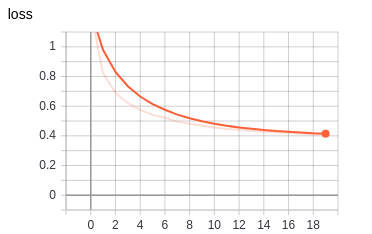

In [65]:
from IPython.display import Image
Image('./tensorboard pics/model_1_train_loss.png')

**model 1: Train AUC**

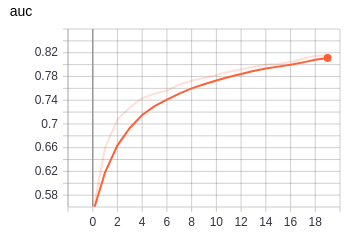

In [66]:
Image('./tensorboard pics/model_1_train_AUC.png')

**Model 1: Validation loss**

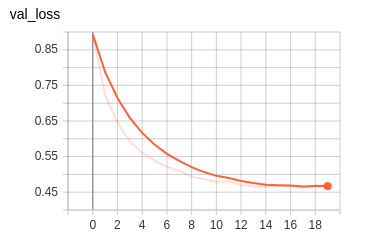

In [67]:
Image('./tensorboard pics/model_1_val_loss.png')

**Model 1: Validation AUC**

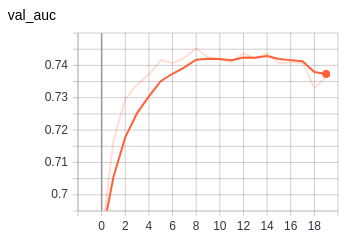

In [68]:
Image('./tensorboard pics/model_1_val_AUC.png')

In [143]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['#', 'Train Loss', 'Train AUC', 'Validation Loss', 'Validation AUC', 'Test Loss', 'Test AUC']
table.add_row(['Model 1', '0.40', '0.81', '0.46', '0.73', '0.38', '0.74'])

# Model 2

In this model, the architecture of the neural net remains the same, but the words in the Essays are filtered based on their IDF values.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
df_X_train.essay.head()

39038     my students super learners they come diverse b...
105236    as teacher low income high poverty school dist...
11584     my second graders active energetic students lo...
9664      my students five years old for second year sch...
3696      the students class multisensory learners thriv...
Name: essay, dtype: object

Create a TFIDF object and fit it on the train data

In [71]:
tfidf = TfidfVectorizer()
tfidf_essay_fit = tfidf.fit_transform(df_X_train.essay)

In [72]:
tfidf.idf_.shape, len(tfidf.get_feature_names())

((47416,), 47416)

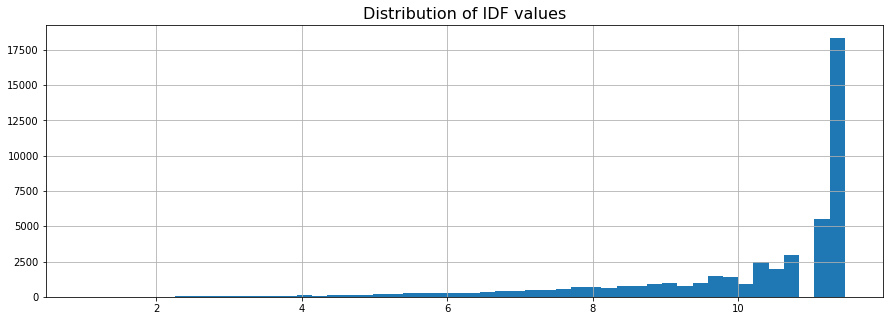

In [73]:
plt.figure(figsize=(15,5))
plt.hist(tfidf.idf_, bins=50)
plt.grid()
plt.title('Distribution of IDF values', fontsize=16)
plt.show()

The bottom 1 percentile and the last 1 percentile IDF values

In [75]:
np.percentile(tfidf.idf_, 1),np.percentile(tfidf.idf_, 99)

(4.052052837889417, 11.4619455276077)

How the IDF values are distributed across all the words in the training corpus

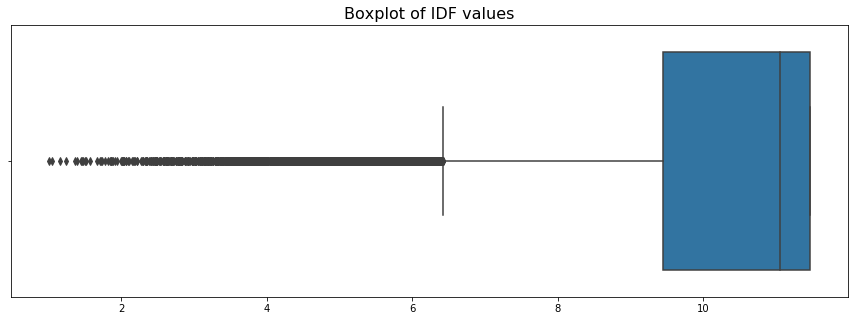

In [76]:
import seaborn as sbn
plt.figure(figsize=(15,5))
sbn.boxplot(tfidf.idf_)
plt.title('Boxplot of IDF values', fontsize=16)
plt.show()

Create a mapping for words to their IDF values

In [77]:
dict_word_to_IDF_mapping = dict(zip(tfidf.get_feature_names(), tfidf.idf_.tolist()))

**Function to remove the words with IDF values outside our thresholds (< 1 percentile and >99 percentile)**

In [78]:
def remove_extremeIDFwords(x):
    lowIDF=4.052052837889417
    highIDF=11.4619455276077
    
    filtered_words = []
    for word in x.split():
        
        try:
            idf_value = dict_word_to_IDF_mapping[word]
        except:
            continue
        
        if  (idf_value > lowIDF) and (idf_value < highIDF):
            filtered_words.append(word)
                
    return ' '.join(filtered_words)

Filter all the datasets on the IDF values using the above function 

In [79]:
df_X_train['essay_IDF'] = df_X_train.essay.map(remove_extremeIDFwords)
df_X_CV['essay_IDF'] = df_X_CV.essay.map(remove_extremeIDFwords)
df_X_test['essay_IDF'] = df_X_test.essay.map(remove_extremeIDFwords)

In [80]:
df_X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,essay_IDF
39038,la,mrs,grades_3_5,2,appliedlearning history_civics,communityservice socialsciences,my students super learners they come diverse b...,680.47,super ultimately super leaders compassionate i...
105236,ny,teacher,grades_3_5,10,math_science,environmentalscience health_lifescience,as teacher low income high poverty school dist...,256.56,faced researching visual tactile color coded c...
11584,ca,mrs,grades_prek_2,4,health_sports specialneeds,gym_fitness specialneeds,my second graders active energetic students lo...,59.49,typical collaborate fellow simply spot warm in...
9664,va,ms,grades_prek_2,3,literacy_language math_science,literature_writing mathematics,my students five years old for second year sch...,197.13,five went virginia preschool initiative vpi fo...
3696,ny,ms,grades_prek_2,1,specialneeds,specialneeds,the students class multisensory learners thriv...,212.16,multisensory thrive according style sing dance...


**Tokenize the essays**

Earlier, for the previous model, we did this on the entire essay. This time, we've already filtered the words based on IDF.

In [81]:
t_essays = Tokenizer()
t_essays.fit_on_texts(df_X_train.essay_IDF.tolist())
encoded_docs_train = t_essays.texts_to_sequences(df_X_train.essay_IDF.tolist())

In [82]:
vocab_size_essays = len(t_essays.word_index) + 1
print(vocab_size_essays)

28607


**obtain the tokenized essay representation for CV and Test sets**

In [83]:
encoded_docs_CV = t_essays.texts_to_sequences(df_X_CV.essay_IDF.tolist())
encoded_docs_test = t_essays.texts_to_sequences(df_X_test.essay_IDF.tolist())

**Pad the inputs**

Instead of padding all the essays (docs) with the same maximum length, let's see how the number of words in essays are distributed.

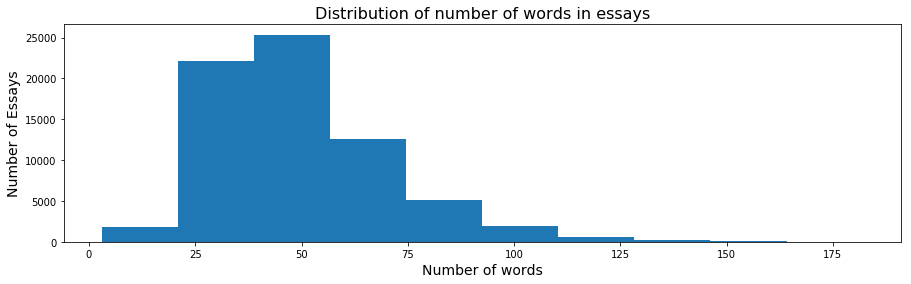

In [84]:
df_X_train.essay_IDF.str.split().apply(len).plot.hist(figsize=(15,4))
plt.title('Distribution of number of words in essays', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Number of Essays', fontsize=14)
plt.show()

**The 95th percentile of #words in essay_IDF is 89**. Which means most of the essays have much lower word count than the essay with maximum word count(182) in the dataset. If we pad the lengths to `182`, most of the other essays would have redundant 0 inputs. Instead, let's keep the max length of essay inputs to 89. Doing this would also improve the training time because less number of parameters would have to be trained.

In [85]:
pctile_95_wc = df_X_train.essay_IDF.str.split().apply(len).quantile(.95)
max_wc = df_X_train.essay_IDF.str.split().apply(len).max()

print('95th Percentile word count in Essays:', pctile_95_wc)
print('Maximum word count in essays:', max_wc)

95th Percentile word count in Essays: 89.0
Maximum word count in essays: 182


In [88]:
padded_docs_train = pad_sequences(encoded_docs_train,
                                  maxlen=int(pctile_95_wc),
                                  padding='post',
                                  truncating='post')
padded_docs_CV = pad_sequences(encoded_docs_CV,
                               maxlen=int(pctile_95_wc),
                               padding='post',
                               truncating='post')
padded_docs_test = pad_sequences(encoded_docs_test,
                                 maxlen=int(pctile_95_wc),
                                 padding='post',
                                 truncating='post')

In [89]:
padded_docs_train.shape ,padded_docs_CV.shape, padded_docs_test.shape

((69918, 89), (17480, 89), (21850, 89))

Generate the embedding matrix again, since we've retrained the `t_essays` TFIDF object.

In [90]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size_essays, 300))
for word, i in t_essays.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Define the embedding layer for essays**

In [91]:
essay_input = Input(shape=(padded_docs_train.shape[1], ))

e = Embedding(vocab_size_essays,
              300,
              weights=[embedding_matrix],
              input_length=padded_docs_train.shape[1],
              trainable=False,
              batch_size=64)(essay_input)

lstm_out_essay = LSTM(units=128,
                      recurrent_dropout=0.45, kernel_regularizer=regularizers.l2(0.001),
                      input_shape=(padded_docs_train.shape[1], 300),
                      return_sequences=True)(e)

lstm_out_flattened = Flatten()(lstm_out_essay)

**Concatenate the flattened vectors for model 2**

Here, note that we've only created `lstm_out_flattened` tensor again. Because the others have remained unchanged since model 1. We can use them directly as they are.

In [92]:
merged = concatenate([
    lstm_out_flattened, flatten_school_state_out,
    flatten_project_grade_cat_out, flatten_clean_category,
    flatten_clean_subcategory, flatten_teacher_prefix, out_other_features
])

In [289]:
type(merged)

tensorflow.python.framework.ops.Tensor

# Add the following Dense and Dropout layers

In [93]:
x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(merged)
x = Dropout(.5)(x)
x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)

**Create a final model of the whole architecture**

In [94]:
final_model_2 = Model(inputs=[
    essay_input, input_layer_school_state, input_layer_project_grade_cat,
    input_layer_clean_category, input_layer_clean_subcategory,
    input_layer_teacher_prefix, input_layer_pp_price
],
                    outputs=[main_output])

In [84]:
final_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      7968300     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

**Tree representation of Model 2**

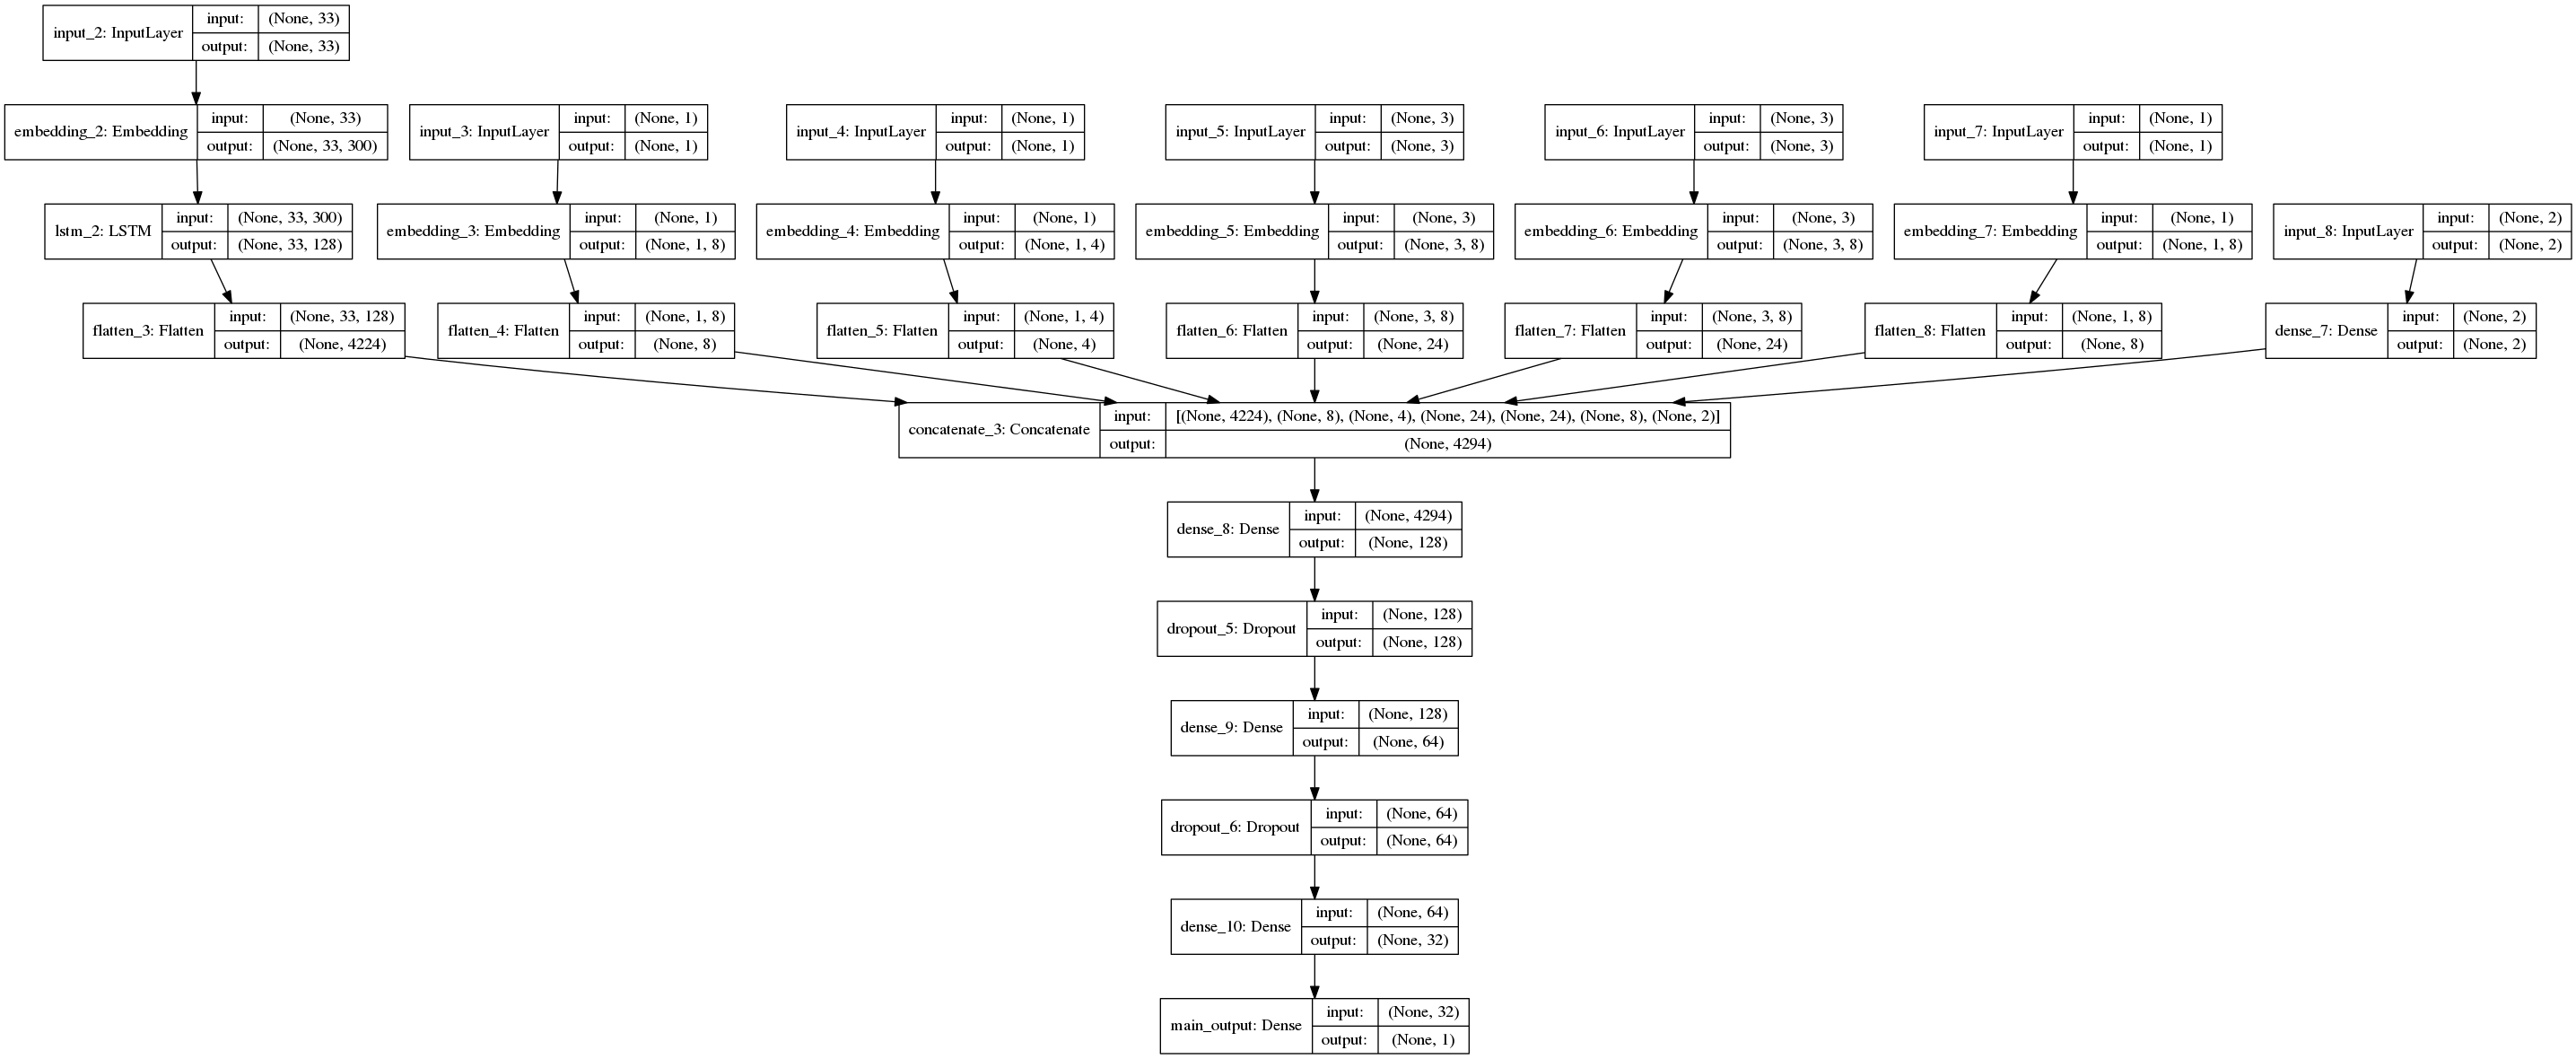

In [95]:
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(final_model_2, show_shapes=True, show_layer_names=True, to_file='model_2.png')
from IPython.display import Image
Image(retina=True, filename='model_2.png')

## Compile the model

In [96]:
from keras.optimizers import Adam
adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
final_model_2.compile(optimizer=adm, loss='binary_crossentropy', metrics=['accuracy', auc])

In [97]:
tb_2 = TensorBoard(log_dir="logs/{}".format(time()))

In [98]:
%%notify

final_model_2.fit([
    padded_docs_train, padded_school_states_train,
    padded_project_grade_cats_train, padded_clean_category_train,
    padded_clean_subcategory_train, padded_teacher_prefix_train,
    other_features_train
], [y_train],
                epochs=20,
                batch_size=1024,validation_data=([
                    padded_docs_CV, padded_school_states_CV,
                    padded_project_grade_cats_CV, padded_clean_category_CV,
                    padded_clean_subcategory_CV, padded_teacher_prefix_CV, other_features_CV
                ], [y_CV]),
                 callbacks=[ tb_2])

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 14s 200us/step - loss: 1.0394 - acc: 0.8277 - auc: 0.6077 - val_loss: 0.7865 - val_acc: 0.8481 - val_auc: 0.6937
Epoch 2/20
69918/69918 [==============================] - 12s 177us/step - loss: 0.7111 - acc: 0.8470 - auc: 0.6815 - val_loss: 0.6439 - val_acc: 0.8465 - val_auc: 0.7045
Epoch 3/20
69918/69918 [==============================] - 12s 179us/step - loss: 0.6072 - acc: 0.8486 - auc: 0.7043 - val_loss: 0.5746 - val_acc: 0.8494 - val_auc: 0.7053
Epoch 4/20
69918/69918 [==============================] - 13s 180us/step - loss: 0.5501 - acc: 0.8495 - auc: 0.7107 - val_loss: 0.5322 - val_acc: 0.8481 - val_auc: 0.7055
Epoch 5/20
69918/69918 [==============================] - 13s 180us/step - loss: 0.5113 - acc: 0.8499 - auc: 0.7181 - val_loss: 0.5069 - val_acc: 0.8476 - val_auc: 0.7056
Epoch 6/20
69918/69918 [==============================] - 13s 179us/step - loss: 0.4859 - acc: 

<IPython.core.display.Javascript object>

**Make predictions on test data**

In [99]:
predictions_model2 = final_model_2.predict([
    padded_docs_test, padded_school_states_test,
    padded_project_grade_cats_test, padded_clean_category_test,
    padded_clean_subcategory_test, padded_teacher_prefix_test,
    other_features_test
])

**Calculate the AUC on test data**

In [100]:
roc_auc_score(y_test, predictions_model2)

0.7113772330405796

**Log loss on test data: Model 2**

In [101]:
log_loss(y_test, predictions_model2)

0.3878562624428157

In [145]:
table.add_row(['Model 2', '0.40', '0.75', '0.42', '0.71', '0.38', '0.71'])

**Model 2: Train loss**

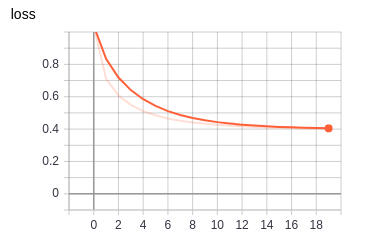

In [102]:
from IPython.display import Image
Image('./tensorboard pics/model_2_train_loss.png')

**model 2: Train AUC**

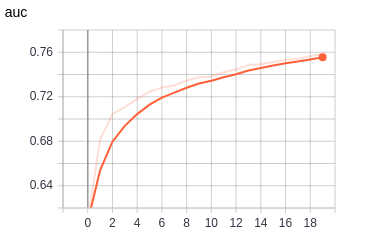

In [103]:
Image('./tensorboard pics/model_2_train_AUC.png')

**Model 2: Validation loss**

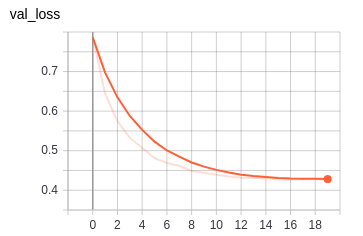

In [104]:
Image('./tensorboard pics/model_2_val_loss.png')

**Model 2: Validation AUC**

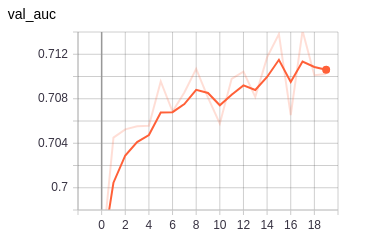

In [105]:
Image('./tensorboard pics/model_2_val_AUC.png')

# Model 3

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [107]:
df_X_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'essay_IDF'],
      dtype='object')

In [108]:
df_donors.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

**School state 1 hot encoded**

In [109]:
vec = CountVectorizer(binary=False)

school_state_train_1hot = vec.fit_transform(df_X_train['school_state'])
school_state_CV_1hot = vec.transform(df_X_CV['school_state'])
school_state_test_1hot = vec.transform(df_X_test['school_state'])

**Teacher prefix 1 hot encoded**

In [110]:
vec = CountVectorizer(binary=False)

teacher_prefix_train_1hot = vec.fit_transform(df_X_train['teacher_prefix'])
teacher_prefix_CV_1hot = vec.transform(df_X_CV['teacher_prefix'])
teacher_prefix_test_1hot = vec.transform(df_X_test['teacher_prefix'])

In [111]:
teacher_prefix_train_1hot.toarray().shape

(69918, 5)

**Project grade category 1 hot encoded**

In [112]:
vec = CountVectorizer(binary=False)

project_grade_category_train_1hot = vec.fit_transform(df_X_train['project_grade_category'])
project_grade_category_CV_1hot = vec.transform(df_X_CV['project_grade_category'])
project_grade_category_test_1hot = vec.transform(df_X_test['project_grade_category'])

In [113]:
project_grade_category_train_1hot.toarray().shape

(69918, 4)

**clean_categories 1 hot encoded**

In [114]:
vec = CountVectorizer(binary=False)

clean_categories_train_1hot = vec.fit_transform(
    df_X_train['clean_categories'])

clean_categories_CV_1hot = vec.transform(
    df_X_CV['clean_categories'])

clean_categories_test_1hot = vec.transform(
    df_X_test['clean_categories'])

**Clean subcategories**

In [115]:
vec = CountVectorizer(binary=False)

clean_subcategories_train_1hot = vec.fit_transform(
    df_X_train['clean_subcategories'])

clean_subcategories_CV_1hot = vec.transform(
    df_X_CV['clean_subcategories'])

clean_subcategories_test_1hot = vec.transform(
    df_X_test['clean_subcategories'])

**Stack all 1 hot encoded features together**

In [116]:
other_features_train = hstack([
    school_state_train_1hot, teacher_prefix_train_1hot,
    project_grade_category_train_1hot, clean_categories_train_1hot,
    clean_subcategories_train_1hot
]).todense()

other_features_CV = hstack([
    school_state_CV_1hot, teacher_prefix_CV_1hot,
    project_grade_category_CV_1hot, clean_categories_CV_1hot,
    clean_subcategories_CV_1hot
]).todense()


other_features_test = hstack([
    school_state_test_1hot, teacher_prefix_test_1hot,
    project_grade_category_test_1hot, clean_categories_test_1hot,
    clean_subcategories_test_1hot
]).todense()


In [117]:
other_features_train.shape, other_features_CV.shape, other_features_test.shape

((69918, 99), (17480, 99), (21850, 99))

**Numerical features**

In [118]:
X_train_ppp = df_X_train[[
    'teacher_number_of_previously_posted_projects', 'price'
]].values.reshape(-1, 2)

X_CV_ppp = df_X_CV[['teacher_number_of_previously_posted_projects',
                    'price']].values.reshape(-1, 2)

X_test_ppp = df_X_test[[
    'teacher_number_of_previously_posted_projects', 'price'
]].values.reshape(-1, 2)

In [119]:
scaler = StandardScaler()

X_train_ppp = scaler.fit_transform(X_train_ppp)
X_CV_ppp = scaler.transform(X_CV_ppp)
X_test_ppp = scaler.transform(X_test_ppp)

**Stack all features together**

In [120]:
X_train = np.hstack([other_features_train, X_train_ppp])
X_CV = np.hstack([other_features_CV, X_CV_ppp])
X_test = np.hstack([other_features_test, X_test_ppp])

In [121]:
X_train = np.expand_dims(X_train,2)
X_CV = np.expand_dims(X_CV,2)
X_test = np.expand_dims(X_test,2)

In [122]:
X_train.shape

(69918, 101, 1)

In [123]:
inp_conv =  Input(shape=(101,1),name='all_features')
x1 = Conv1D(filters=128, kernel_size=(3), activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=128, kernel_size=(3), activation='relu',kernel_initializer="he_normal")(x1)
x3 = Flatten()(x1)

**concatenate the outputs**

In [124]:
merged = concatenate([lstm_out_flattened, x3])

x = Dense(128,
          activation="relu",
          kernel_initializer="he_normal",
          kernel_regularizer=regularizers.l2(0.001))(merged)

x=Dropout(0.5)(x)

x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

x=Dropout(0.3)(x)

x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(1, activation='sigmoid', name='output')(x)
final_model_3 = Model(inputs=[essay_input,inp_conv],outputs=[output])

In [125]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
final_model_3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', auc])

In [40]:
final_model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 231)          0                                            
__________________________________________________________________________________________________
all_features (InputLayer)       (None, 101, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 231, 300)     14160600    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 99, 128)      512         all_features[0][0]               
__________________________________________________________________________________________________
lstm_1 (LS

In [126]:
tb_3 = TensorBoard(log_dir="logs/{}".format(time()))

**Visual representation of model 3**

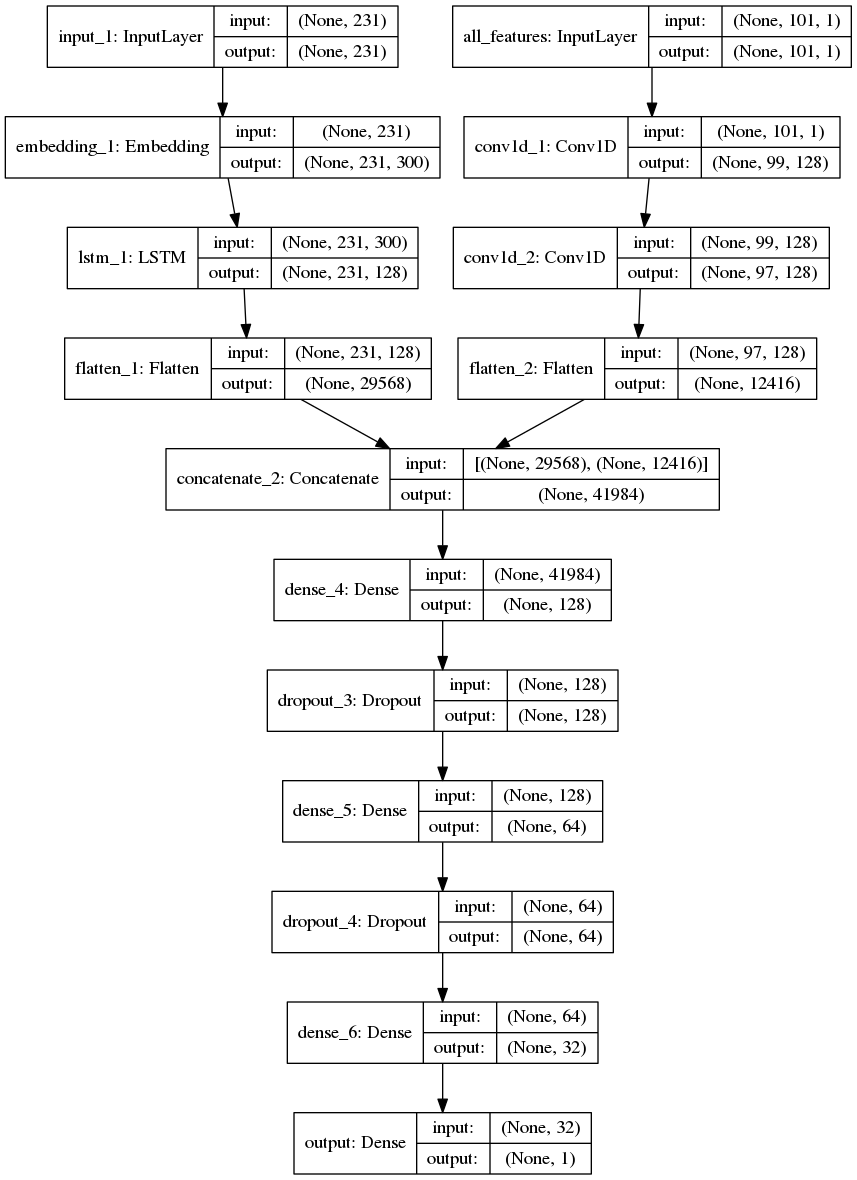

In [96]:
plot_model(model_3, show_shapes=True, show_layer_names=True, to_file='model_3.png')
Image(retina=True, filename='model_3.png')

In [127]:
%%notify

final_model_3.fit([padded_docs_train, X_train], [y_train],
            epochs=20,
            batch_size=1024,
            validation_data=([padded_docs_CV, X_CV], [y_CV]),
            callbacks=[tb_3])

Train on 69918 samples, validate on 17480 samples
Epoch 1/20
69918/69918 [==============================] - 18s 255us/step - loss: 0.6856 - acc: 0.8408 - auc: 0.6569 - val_loss: 0.5654 - val_acc: 0.8479 - val_auc: 0.7195
Epoch 2/20
69918/69918 [==============================] - 14s 196us/step - loss: 0.5305 - acc: 0.8483 - auc: 0.7124 - val_loss: 0.4985 - val_acc: 0.8479 - val_auc: 0.7180
Epoch 3/20
69918/69918 [==============================] - 14s 198us/step - loss: 0.4823 - acc: 0.8484 - auc: 0.7217 - val_loss: 0.4675 - val_acc: 0.8479 - val_auc: 0.7226
Epoch 4/20
69918/69918 [==============================] - 14s 195us/step - loss: 0.4543 - acc: 0.8485 - auc: 0.7260 - val_loss: 0.4452 - val_acc: 0.8479 - val_auc: 0.7200
Epoch 5/20
69918/69918 [==============================] - 14s 196us/step - loss: 0.4366 - acc: 0.8485 - auc: 0.7304 - val_loss: 0.4330 - val_acc: 0.8479 - val_auc: 0.7218
Epoch 6/20
69918/69918 [==============================] - 14s 197us/step - loss: 0.4261 - acc: 

<IPython.core.display.Javascript object>

**Make predictions on test data**

In [130]:
predictions_model3 = final_model_3.predict([padded_docs_test, X_test])

**Calculate the AUC on test data**

In [131]:
roc_auc_score(y_test, predictions_model3)

0.7255770174096867

**Log loss on test data: Model 3**

In [132]:
log_loss(y_test, predictions_model3)

0.3791596134759707

In [146]:
table.add_row(['Model 3', '0.39', '0.75', '0.41', '0.72', '0.37', '0.72'])

**Model 3: Train loss**

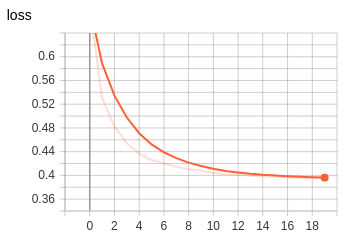

In [133]:
from IPython.display import Image
Image('./tensorboard pics/model_3_train_loss.png')

**model 3: Train AUC**

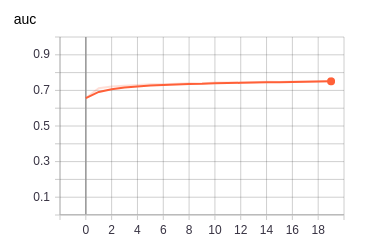

In [134]:
Image('./tensorboard pics/model_3_train_AUC.png')

**Model 3: Validation loss**

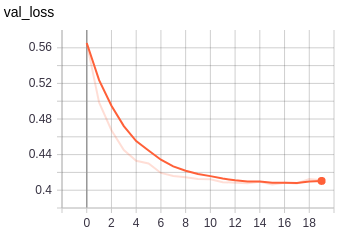

In [135]:
Image('./tensorboard pics/model_3_val_loss.png')

**Model 3: Validation AUC**

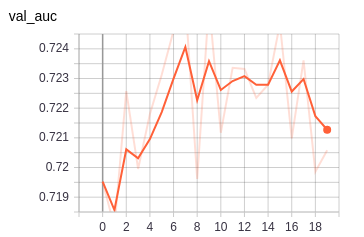

In [136]:
Image('./tensorboard pics/model_3_val_AUC.png')

# Concluding Remarks

* We tried out 3 different Neaural net models for this classification problem. The first two models had the same architecture, but varying number of essay features and used LSTMs.

* We used Tensorboard to analyze how the loss and AUC varies with each epoch.


* The best AUC observed on test data was ~0.74 with Model 1. Following tables contains the summary of the models trained.

In [147]:
print(table)

+---------+------------+-----------+-----------------+----------------+-----------+----------+
|    #    | Train Loss | Train AUC | Validation Loss | Validation AUC | Test Loss | Test AUC |
+---------+------------+-----------+-----------------+----------------+-----------+----------+
| Model 1 |    0.40    |    0.81   |       0.46      |      0.73      |    0.38   |   0.74   |
| Model 2 |    0.40    |    0.75   |       0.42      |      0.71      |    0.38   |   0.71   |
| Model 3 |    0.39    |    0.75   |       0.41      |      0.72      |    0.37   |   0.72   |
+---------+------------+-----------+-----------------+----------------+-----------+----------+
